In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test


from keras.models import Model
from keras.layers import *
from keras.initializers import * 
from keras.layers.merge import concatenate

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def highway_conv_1d(inputLayer, filtersNumber, dropout = 0.2, keepInitialBias = -1):
    highwayInput = Input(shape=(400, 300))
    convolution = one_by_one(filtersNumber, highwayInput, dropout)
    
    keep = Conv1D(
        filtersNumber, 1, 
        activation = 'sigmoid',
        padding = 'same', 
        kernel_initializer = 'he_uniform',
        bias_initializer = Constant(keepInitialBias)
    )(highwayInput)
    
    keep = BatchNormalization()(keep)
    forget = Lambda(lambda layer: 1 - layer)(keep)
    
    gate = add(
        [
            multiply([keep, convolution]),
            multiply([forget, highwayInput])
        ]
    )
    
    return Model(inputs=[highwayInput], outputs = [gate])(inputLayer)

In [0]:
def highway_block(inputLayer, filtersNumber, convolutions = 3):
    block = inputLayer
    for i in range(convolutions):
       block = highway_conv_1d(block, filtersNumber)
    return block

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

highway = highway_block(embedding_dropout, 300, 6)

features = yoon_kim_feature_extractor(filtersNumber, highway)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21312/102124 [=====>........................] - ETA: 12:22 - loss: 0.2389 - acc: 0.9189

102112/102124 [============================>.] - ETA: 0s - loss: 0.1282 - acc: 0.9588

102124/102124 [==============================] - 983s 10ms/step - loss: 0.1282 - acc: 0.9588 - val_loss: 0.0846 - val_acc: 0.9739
Epoch 2/32
 10112/102124 [=>............................] - ETA: 13:35 - loss: 0.0863 - acc: 0.9724

102112/102124 [============================>.] - ETA: 0s - loss: 0.0815 - acc: 0.9732

102124/102124 [==============================] - 976s 10ms/step - loss: 0.0815 - acc: 0.9732 - val_loss: 0.0765 - val_acc: 0.9748
roc-auc: 0.9386 - roc-auc_val: 0.9374                                                                                                    
Epoch 3/32
  8672/102124 [=>............................] - ETA: 13:49 - loss: 0.0815 - acc: 0.9732

102112/102124 [============================>.] - ETA: 0s - loss: 0.0806 - acc: 0.9737

102124/102124 [==============================] - 976s 10ms/step - loss: 0.0806 - acc: 0.9737 - val_loss: 0.0816 - val_acc: 0.9729
Epoch 4/32
 10112/102124 [=>............................] - ETA: 13:36 - loss: 0.0768 - acc: 0.9752

102112/102124 [============================>.] - ETA: 0s - loss: 0.0759 - acc: 0.9745

102124/102124 [==============================] - 977s 10ms/step - loss: 0.0759 - acc: 0.9745 - val_loss: 0.0750 - val_acc: 0.9722
roc-auc: 0.9531 - roc-auc_val: 0.952                                                                                                    
Epoch 5/32
  8672/102124 [=>............................] - ETA: 13:48 - loss: 0.0739 - acc: 0.9753

102112/102124 [============================>.] - ETA: 0s - loss: 0.0749 - acc: 0.9743

102124/102124 [==============================] - 977s 10ms/step - loss: 0.0749 - acc: 0.9743 - val_loss: 0.0840 - val_acc: 0.9689
Epoch 6/32
 10112/102124 [=>............................] - ETA: 13:37 - loss: 0.0721 - acc: 0.9746

102112/102124 [============================>.] - ETA: 0s - loss: 0.0725 - acc: 0.9748

102124/102124 [==============================] - 977s 10ms/step - loss: 0.0725 - acc: 0.9748 - val_loss: 0.0723 - val_acc: 0.9728
roc-auc: 0.9573 - roc-auc_val: 0.9564                                                                                                    
Epoch 7/32
  8672/102124 [=>............................] - ETA: 13:49 - loss: 0.0724 - acc: 0.9755

102112/102124 [============================>.] - ETA: 0s - loss: 0.0714 - acc: 0.9754

102124/102124 [==============================] - 977s 10ms/step - loss: 0.0714 - acc: 0.9754 - val_loss: 0.0795 - val_acc: 0.9697
Epoch 8/32
 10112/102124 [=>............................] - ETA: 13:36 - loss: 0.0686 - acc: 0.9762

102112/102124 [============================>.] - ETA: 0s - loss: 0.0707 - acc: 0.9757

102124/102124 [==============================] - 977s 10ms/step - loss: 0.0707 - acc: 0.9757 - val_loss: 0.0712 - val_acc: 0.9729
roc-auc: 0.9583 - roc-auc_val: 0.9591                                                                                                    
Epoch 9/32
  8672/102124 [=>............................] - ETA: 13:48 - loss: 0.0707 - acc: 0.9750

102112/102124 [============================>.] - ETA: 0s - loss: 0.0702 - acc: 0.9758

102124/102124 [==============================] - 977s 10ms/step - loss: 0.0702 - acc: 0.9758 - val_loss: 0.0685 - val_acc: 0.9744
Epoch 10/32
 10080/102124 [=>............................] - ETA: 13:36 - loss: 0.0716 - acc: 0.9759

102112/102124 [============================>.] - ETA: 0s - loss: 0.0702 - acc: 0.9758

102124/102124 [==============================] - 977s 10ms/step - loss: 0.0702 - acc: 0.9758 - val_loss: 0.0754 - val_acc: 0.9716
roc-auc: 0.9588 - roc-auc_val: 0.9578                                                                                                    
Epoch 11/32
  8640/102124 [=>............................] - ETA: 13:49 - loss: 0.0720 - acc: 0.9749

102112/102124 [============================>.] - ETA: 0s - loss: 0.0700 - acc: 0.9756

102124/102124 [==============================] - 977s 10ms/step - loss: 0.0700 - acc: 0.9756 - val_loss: 0.0733 - val_acc: 0.9728

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00017677669529803097.
Epoch 12/32
  7968/102124 [=>............................] - ETA: 13:55 - loss: 0.0739 - acc: 0.9745

102112/102124 [============================>.] - ETA: 0s - loss: 0.0692 - acc: 0.9760

102124/102124 [==============================] - 977s 10ms/step - loss: 0.0692 - acc: 0.9760 - val_loss: 0.0726 - val_acc: 0.9722
roc-auc: 0.9584 - roc-auc_val: 0.9593                                                                                                    
Epoch 13/32
  8640/102124 [=>............................] - ETA: 13:49 - loss: 0.0693 - acc: 0.9764

102112/102124 [============================>.] - ETA: 0s - loss: 0.0690 - acc: 0.9760

102124/102124 [==============================] - 977s 10ms/step - loss: 0.0690 - acc: 0.9760 - val_loss: 0.0710 - val_acc: 0.9736
Epoch 14/32
 10080/102124 [=>............................] - ETA: 13:37 - loss: 0.0682 - acc: 0.9763

102112/102124 [============================>.] - ETA: 0s - loss: 0.0686 - acc: 0.9762

102124/102124 [==============================] - 977s 10ms/step - loss: 0.0686 - acc: 0.9762 - val_loss: 0.0735 - val_acc: 0.9744
roc-auc: 0.9614 - roc-auc_val: 0.9603                                                                                                    
Epoch 15/32
  8640/102124 [=>............................] - ETA: 13:49 - loss: 0.0660 - acc: 0.9775

102112/102124 [============================>.] - ETA: 0s - loss: 0.0682 - acc: 0.9761

102124/102124 [==============================] - 977s 10ms/step - loss: 0.0682 - acc: 0.9761 - val_loss: 0.0751 - val_acc: 0.9730
Epoch 16/32
 10080/102124 [=>............................] - ETA: 13:37 - loss: 0.0690 - acc: 0.9753

102112/102124 [============================>.] - ETA: 0s - loss: 0.0674 - acc: 0.9762

102124/102124 [==============================] - 977s 10ms/step - loss: 0.0674 - acc: 0.9762 - val_loss: 0.0794 - val_acc: 0.9729
roc-auc: 0.9597 - roc-auc_val: 0.9586                                                                                                    
Epoch 17/32
  8640/102124 [=>............................] - ETA: 13:49 - loss: 0.0666 - acc: 0.9763

102112/102124 [============================>.] - ETA: 0s - loss: 0.0677 - acc: 0.9765

102124/102124 [==============================] - 977s 10ms/step - loss: 0.0677 - acc: 0.9765 - val_loss: 0.0689 - val_acc: 0.9750
Epoch 18/32
 10080/102124 [=>............................] - ETA: 13:37 - loss: 0.0657 - acc: 0.9770

102112/102124 [============================>.] - ETA: 0s - loss: 0.0670 - acc: 0.9767

102124/102124 [==============================] - 977s 10ms/step - loss: 0.0670 - acc: 0.9767 - val_loss: 0.0775 - val_acc: 0.9726
roc-auc: 0.9609 - roc-auc_val: 0.9608                                                                                                    
Epoch 19/32
  8640/102124 [=>............................] - ETA: 13:50 - loss: 0.0645 - acc: 0.9773

102112/102124 [============================>.] - ETA: 0s - loss: 0.0663 - acc: 0.9768

102124/102124 [==============================] - 977s 10ms/step - loss: 0.0663 - acc: 0.9768 - val_loss: 0.0711 - val_acc: 0.9742


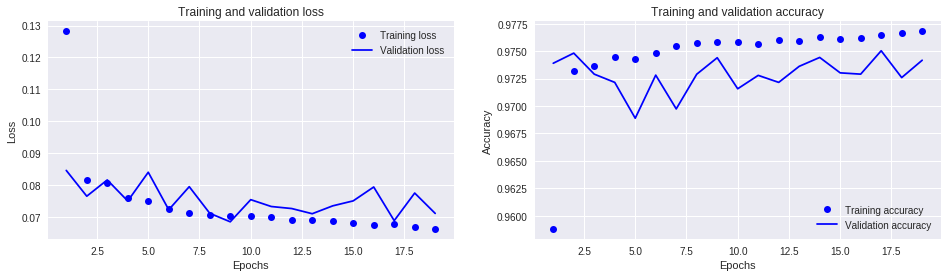

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 92s 3ms/step
([0.07074385914597302, 0.9746931896843956], 0.9617707893719548)
